## POS tagging using modified Viterbi

### Data Preparation

In [57]:
#Importing libraries
import nltk
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [58]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [59]:
train_set, val_set = train_test_split(nltk_data, test_size=0.05)

### Build the vanilla Viterbi based POS tagger

In [60]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95509

In [61]:
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Your',
 'research',
 'stopped',
 'when',
 'a',
 'convenient',
 'assertion',
 'could',
 'be',
 'made']

In [62]:
V = set(tokens)
print(len(V))

12063


In [63]:
T = set([pair[1] for pair in train_tagged_words])
print(len(T))
T

12


{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [64]:
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [65]:
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    return (count_w_given_tag, count_tag)

In [66]:
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [67]:
tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [68]:
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df.head()

,ADV,DET,.,VERB,NOUN,CONJ,ADP,PRON,X,NUM,ADJ,PRT
ADV,0.080586,0.068265,0.137862,0.344322,0.031302,0.006993,0.117882,0.015651,0.022311,0.029970,0.130203,0.014652
DET,0.012777,0.005545,0.017117,0.039778,0.637898,0.000482,0.009041,0.003616,0.046167,0.021697,0.205641,0.000241
.,0.052812,0.175439,0.092308,0.089429,0.221952,0.058120,0.090958,0.065227,0.026361,0.080792,0.044354,0.002159
VERB,0.081089,0.134475,0.035331,0.170973,0.109883,0.005603,0.089883,0.035175,0.217510,0.022957,0.065447,0.031673
NOUN,0.016895,0.013209,0.240175,0.146068,0.263820,0.042948,0.177522,0.004817,0.028973,0.009597,0.012516,0.043459


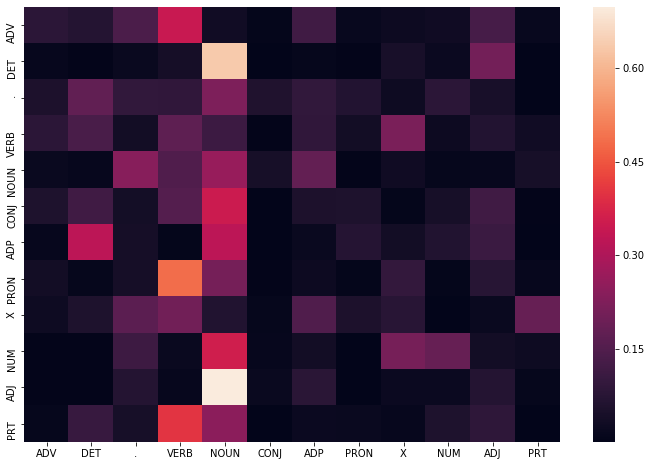

In [69]:
plt.figure(figsize=(12,8))
sns.heatmap(tags_df)
plt.show()

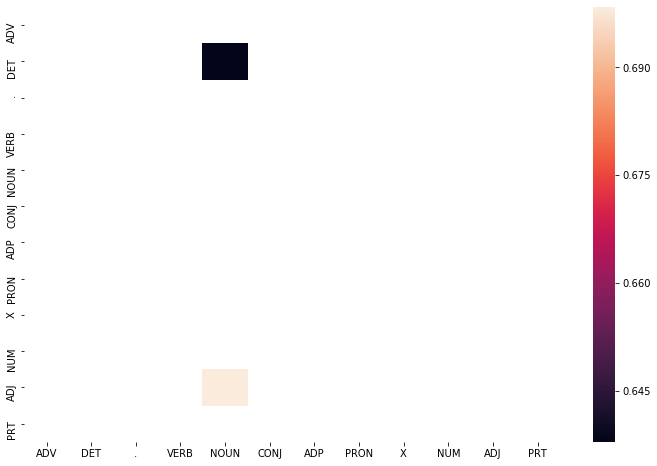

In [70]:
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(12,8))
sns.heatmap(tags_frequent)
plt.show()

In [71]:
# Viterbi Heuristic
def Viterbi(words, train_bag=train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key],tag)[1]
            state_probability = emission_p*transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [72]:
random.seed(1234)
rndom = [random.randint(1,len(val_set)) for x in range(5)]
val_run = [val_set[i] for i in rndom]
val_run_base = [tup for sent in val_run for tup in sent]
val_tagged_words = [tup[0] for sent in val_run for tup in sent]
val_run

[[('Mr.', 'NOUN'),
  ('van', 'NOUN'),
  ('Dover', 'NOUN'),
  ('said', 'VERB'),
  ('0', 'X'),
  ('the', 'DET'),
  ('crystal', 'NOUN'),
  ('changes', 'VERB'),
  ('0', 'X'),
  ('his', 'PRON'),
  ('team', 'NOUN'),
  ('introduced', 'VERB'),
  ('*T*-1', 'X'),
  ('apparently', 'ADV'),
  ('pins', 'VERB'),
  ('the', 'DET'),
  ('magnetic', 'ADJ'),
  ('fields', 'NOUN'),
  ('in', 'ADP'),
  ('place', 'NOUN'),
  (',', '.'),
  ('*', 'X'),
  ('preventing', 'VERB'),
  ('them', 'PRON'),
  ('from', 'ADP'),
  ('*-3', 'X'),
  ('lowering', 'VERB'),
  ('current-carrying', 'ADJ'),
  ('capacity', 'NOUN'),
  ('.', '.')],
 [('The', 'DET'),
  ('administration', 'NOUN'),
  (',', '.'),
  ('*-1', 'X'),
  ('sticking', 'VERB'),
  ('to', 'PRT'),
  ('its', 'PRON'),
  ('vow', 'NOUN'),
  ('of', 'ADP'),
  ('*', 'X'),
  ('avoiding', 'VERB'),
  ('tax', 'NOUN'),
  ('increases', 'NOUN'),
  (',', '.'),
  ('has', 'VERB'),
  ('staunchly', 'ADV'),
  ('opposed', 'VERB'),
  ('cost-sharing', 'NOUN'),
  ('.', '.')],
 [('Carnival', 'NO

In [73]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(val_tagged_words)
print("Time taken in seconds: ", time.time()-start)

Time taken in seconds:  16.626214742660522


In [74]:
check = [i for i, j in zip(tagged_seq, val_run_base) if i == j]
accuracy = len(check)/len(tagged_seq)
accuracy

0.9191176470588235

In [75]:
incorrect_tagged_cases = [[val_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, val_run_base)) if j[0]!=j[1]]
print(len(incorrect_tagged_cases))
incorrect_tagged_cases

11


[[('crystal', 'NOUN'), (('changes', 'NOUN'), ('changes', 'VERB'))],
 [('apparently', 'ADV'), (('pins', 'NOUN'), ('pins', 'VERB'))],
 [('*-1', 'X'), (('sticking', 'ADV'), ('sticking', 'VERB'))],
 [('its', 'PRON'), (('vow', 'ADV'), ('vow', 'NOUN'))],
 [('*', 'X'), (('avoiding', 'ADV'), ('avoiding', 'VERB'))],
 [('opposed', 'VERB'), (('cost-sharing', 'ADJ'), ('cost-sharing', 'NOUN'))],
 [('.', '.'), (('ROGERS', 'ADV'), ('ROGERS', 'NOUN'))],
 [('ROGERS', 'NOUN'), (('COMMUNICATIONS', 'ADV'), ('COMMUNICATIONS', 'NOUN'))],
 [('US$', '.'), (('148.9', 'ADV'), ('148.9', 'NUM'))],
 [('$', '.'), (('153.3', 'ADV'), ('153.3', 'NUM'))],
 [('of', 'ADP'), (('perpetual', 'ADV'), ('perpetual', 'ADJ'))]]

In [76]:
# let's check the incorrectly tagged words
incorrect_tagged_words = [j for i, j in enumerate(zip(tagged_seq, val_run_base)) if j[0] != j[1]]
print(len(incorrect_tagged_words))
incorrect_tagged_words

11


[(('changes', 'NOUN'), ('changes', 'VERB')),
 (('pins', 'NOUN'), ('pins', 'VERB')),
 (('sticking', 'ADV'), ('sticking', 'VERB')),
 (('vow', 'ADV'), ('vow', 'NOUN')),
 (('avoiding', 'ADV'), ('avoiding', 'VERB')),
 (('cost-sharing', 'ADJ'), ('cost-sharing', 'NOUN')),
 (('ROGERS', 'ADV'), ('ROGERS', 'NOUN')),
 (('COMMUNICATIONS', 'ADV'), ('COMMUNICATIONS', 'NOUN')),
 (('148.9', 'ADV'), ('148.9', 'NUM')),
 (('153.3', 'ADV'), ('153.3', 'NUM')),
 (('perpetual', 'ADV'), ('perpetual', 'ADJ'))]

In [77]:
val_tokens = set([t for t in val_tagged_words])
unknown_words = list(val_tokens-set(tokens))
print(len(unknown_words))
print(unknown_words)

9
['COMMUNICATIONS', '153.3', 'perpetual', 'vow', 'ROGERS', 'staunchly', 'avoiding', '148.9', 'sticking']


### POS tagging for Test File

In [78]:
f = open('Test_sentences.txt', "r")
test_text = f.read()
test_token = nltk.word_tokenize(test_text)
test_token

['Android',
 'is',
 'a',
 'mobile',
 'operating',
 'system',
 'developed',
 'by',
 'Google',
 '.',
 'Android',
 'has',
 'been',
 'the',
 'best-selling',
 'OS',
 'worldwide',
 'on',
 'smartphones',
 'since',
 '2011',
 'and',
 'on',
 'tablets',
 'since',
 '2013',
 '.',
 'Google',
 'and',
 'Twitter',
 'made',
 'a',
 'deal',
 'in',
 '2015',
 'that',
 'gave',
 'Google',
 'access',
 'to',
 'Twitter',
 "'s",
 'firehose',
 '.',
 'Twitter',
 'is',
 'an',
 'online',
 'news',
 'and',
 'social',
 'networking',
 'service',
 'on',
 'which',
 'users',
 'post',
 'and',
 'interact',
 'with',
 'messages',
 'known',
 'as',
 'tweets',
 '.',
 'Before',
 'entering',
 'politics',
 ',',
 'Donald',
 'Trump',
 'was',
 'a',
 'domineering',
 'businessman',
 'and',
 'a',
 'television',
 'personality',
 '.',
 'The',
 '2018',
 'FIFA',
 'World',
 'Cup',
 'is',
 'the',
 '21st',
 'FIFA',
 'World',
 'Cup',
 ',',
 'an',
 'international',
 'football',
 'tournament',
 'contested',
 'once',
 'every',
 'four',
 'years',
 '.'

In [79]:
start = time.time()
test_tagged_seq = Viterbi(test_token)
print("Time taken in seconds: ", time.time()-start)

Time taken in seconds:  24.164047718048096


In [80]:
test_tagged_seq

[('Android', 'ADV'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'ADV'),
 ('.', '.'),
 ('Android', 'ADV'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'ADV'),
 ('worldwide', 'ADV'),
 ('on', 'ADP'),
 ('smartphones', 'ADV'),
 ('since', 'ADP'),
 ('2011', 'ADV'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'ADV'),
 ('.', '.'),
 ('Google', 'ADV'),
 ('and', 'CONJ'),
 ('Twitter', 'ADV'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'ADV'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'ADV'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'ADV'),
 ("'s", 'PRT'),
 ('firehose', 'ADV'),
 ('.', '.'),
 ('Twitter', 'ADV'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'ADV'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'NOU

### Solve the problem of unknown words
1. Checking accuracy of Unigram/Bigram/Trigram Models with Rule Based Combination  
2. Modified Viterbi Algorithms with Better 2 Performing Models from prior

In [81]:
# specify patterns for tagging example from the NLTK book
patterns = [
    (r'.*ing$', 'VBG'),              # gerund
    (r'.*ed$', 'VBD'),               # past tense
    (r'.*es$', 'VBZ'),               # 3rd singular present
    (r'.*ould$', 'MD'),              # modals
    (r'.*\'s$', 'NN$'),              # possessive nouns
    (r'.*s$', 'NNS'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'CD'), # cardinal numbers
    (r'.*', 'NN')                    # nouns
]

In [82]:
rulebased = nltk.RegexpTagger(patterns)
UnigramModel = nltk.UnigramTagger(train_set, backoff=rulebased)
print("Accuracy Unigram - {}".format(UnigramModel.evaluate(val_set)))

BigramModel = nltk.BigramTagger(train_set, backoff=UnigramModel)
print("Accuracy Bigram - {}".format(BigramModel.evaluate(val_set)))

TrigramModel = nltk.TrigramTagger(train_set, backoff=BigramModel)
print("Accuracy Trigram - {}".format(TrigramModel.evaluate(val_set)))

Accuracy Unigram - 0.9047803367524676
Accuracy Bigram - 0.9057480162570157
Accuracy Trigram - 0.9065221598606541


## Modified Viterbi

In [83]:
# Modified Patterns to solve problem of Unknown Words
modified_patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense
    (r'.*es$', 'VERB'),               # 3rd singular present
    (r'.*ould$', 'X'),                # modals
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'),  # cardinal numbers
    (r'.*', 'NOUN'),                  # nouns
]

In [84]:
rulebased2 = nltk.RegexpTagger(modified_patterns)
UnigramModel2 = nltk.UnigramTagger(train_set, backoff=rulebased2)
print("Accuracy Unigram - {}".format(UnigramModel2.evaluate(val_set)))

BigramModel2 = nltk.BigramTagger(train_set, backoff=UnigramModel2)
print("Accuracy Bigram - {}".format(BigramModel2.evaluate(val_set)))

TrigramModel2 = nltk.TrigramTagger(train_set, backoff=BigramModel2)
print("Accuracy Trigram - {}".format(TrigramModel2.evaluate(val_set)))

Accuracy Unigram - 0.9487129862589511
Accuracy Bigram - 0.9487129862589511
Accuracy Trigram - 0.9487129862589511


## Modified Viterbi 1

In [85]:
# Modified Viterbi Heuristic with RuleBased Tagger
def RuleBasedViterbi(words, train_bag=train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        if word not in tokens:
            unknown_tag = rulebased2.tag_sents([[(word)]])
            for i in unknown_tag:
                for tup in i:
                    state.append(tup[1])
        else:
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]

                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)

            pmax = max(p)
            state_max = T[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))

In [86]:
start = time.time()
final_tagged_seq1 = RuleBasedViterbi(val_tagged_words)
print("Time taken in seconds: ", time.time()-start)

Time taken in seconds:  17.774556636810303


## Modified Viterbi 2

In [87]:
# Modified Viterbi Heuristic with Trigram Tagger
def TrigramViterbi(words, train_bag=train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        if word not in tokens:
            unknown_tag = TrigramModel2.tag_sents([[(word)]])
            for i in unknown_tag:
                for tup in i:
                    state.append(tup[1])
        else:
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]

                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)

            pmax = max(p)
            state_max = T[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))

In [88]:
start = time.time()
final_tagged_seq2 = TrigramViterbi(val_tagged_words)
print("Time taken in seconds: ", time.time()-start)

Time taken in seconds:  21.615761518478394


#### Evaluating tagging accuracy

In [89]:
check2 = [i for i, j in zip(final_tagged_seq1, val_run_base) if i==j]
new_accuracy1 = len(check2)/len(final_tagged_seq1)
new_accuracy1

0.9632352941176471

In [90]:
check3 = [i for i, j in zip(final_tagged_seq2, val_run_base) if i==j]
new_accuracy2 = len(check3)/len(final_tagged_seq2)
new_accuracy2

0.9632352941176471

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [91]:
print(len(incorrect_tagged_words))
incorrect_tagged_words

11


[(('changes', 'NOUN'), ('changes', 'VERB')),
 (('pins', 'NOUN'), ('pins', 'VERB')),
 (('sticking', 'ADV'), ('sticking', 'VERB')),
 (('vow', 'ADV'), ('vow', 'NOUN')),
 (('avoiding', 'ADV'), ('avoiding', 'VERB')),
 (('cost-sharing', 'ADJ'), ('cost-sharing', 'NOUN')),
 (('ROGERS', 'ADV'), ('ROGERS', 'NOUN')),
 (('COMMUNICATIONS', 'ADV'), ('COMMUNICATIONS', 'NOUN')),
 (('148.9', 'ADV'), ('148.9', 'NUM')),
 (('153.3', 'ADV'), ('153.3', 'NUM')),
 (('perpetual', 'ADV'), ('perpetual', 'ADJ'))]

In [92]:
final_incorrect_tagged_words1 = [j for i, j in enumerate(zip(final_tagged_seq1, val_run_base)) if j[0] != j[1]]
print(len(final_incorrect_tagged_words1))
final_incorrect_tagged_words1

5


[(('changes', 'NOUN'), ('changes', 'VERB')),
 (('pins', 'NOUN'), ('pins', 'VERB')),
 (('staunchly', 'NOUN'), ('staunchly', 'ADV')),
 (('cost-sharing', 'ADJ'), ('cost-sharing', 'NOUN')),
 (('perpetual', 'NOUN'), ('perpetual', 'ADJ'))]

In [93]:
final_incorrect_tagged_words2 = [j for i, j in enumerate(zip(final_tagged_seq2, val_run_base)) if j[0] != j[1]]
print(len(final_incorrect_tagged_words2))
final_incorrect_tagged_words2

5


[(('changes', 'NOUN'), ('changes', 'VERB')),
 (('pins', 'NOUN'), ('pins', 'VERB')),
 (('staunchly', 'NOUN'), ('staunchly', 'ADV')),
 (('cost-sharing', 'ADJ'), ('cost-sharing', 'NOUN')),
 (('perpetual', 'NOUN'), ('perpetual', 'ADJ'))]

In [94]:
print(len(incorrect_tagged_cases))
incorrect_tagged_cases

11


[[('crystal', 'NOUN'), (('changes', 'NOUN'), ('changes', 'VERB'))],
 [('apparently', 'ADV'), (('pins', 'NOUN'), ('pins', 'VERB'))],
 [('*-1', 'X'), (('sticking', 'ADV'), ('sticking', 'VERB'))],
 [('its', 'PRON'), (('vow', 'ADV'), ('vow', 'NOUN'))],
 [('*', 'X'), (('avoiding', 'ADV'), ('avoiding', 'VERB'))],
 [('opposed', 'VERB'), (('cost-sharing', 'ADJ'), ('cost-sharing', 'NOUN'))],
 [('.', '.'), (('ROGERS', 'ADV'), ('ROGERS', 'NOUN'))],
 [('ROGERS', 'NOUN'), (('COMMUNICATIONS', 'ADV'), ('COMMUNICATIONS', 'NOUN'))],
 [('US$', '.'), (('148.9', 'ADV'), ('148.9', 'NUM'))],
 [('$', '.'), (('153.3', 'ADV'), ('153.3', 'NUM'))],
 [('of', 'ADP'), (('perpetual', 'ADV'), ('perpetual', 'ADJ'))]]

In [95]:
final_incorrect_tagged_cases1 = [[val_run_base[i-1],j] for i, j in enumerate(zip(final_tagged_seq2, val_run_base)) if j[0]!=j[1]]
print(len(final_incorrect_tagged_cases1))
final_incorrect_tagged_cases1

5


[[('crystal', 'NOUN'), (('changes', 'NOUN'), ('changes', 'VERB'))],
 [('apparently', 'ADV'), (('pins', 'NOUN'), ('pins', 'VERB'))],
 [('has', 'VERB'), (('staunchly', 'NOUN'), ('staunchly', 'ADV'))],
 [('opposed', 'VERB'), (('cost-sharing', 'ADJ'), ('cost-sharing', 'NOUN'))],
 [('of', 'ADP'), (('perpetual', 'NOUN'), ('perpetual', 'ADJ'))]]

In [96]:
final_incorrect_tagged_cases2 = [[val_run_base[i-1],j] for i, j in enumerate(zip(final_tagged_seq2, val_run_base)) if j[0]!=j[1]]
print(len(final_incorrect_tagged_cases2))
final_incorrect_tagged_cases2

5


[[('crystal', 'NOUN'), (('changes', 'NOUN'), ('changes', 'VERB'))],
 [('apparently', 'ADV'), (('pins', 'NOUN'), ('pins', 'VERB'))],
 [('has', 'VERB'), (('staunchly', 'NOUN'), ('staunchly', 'ADV'))],
 [('opposed', 'VERB'), (('cost-sharing', 'ADJ'), ('cost-sharing', 'NOUN'))],
 [('of', 'ADP'), (('perpetual', 'NOUN'), ('perpetual', 'ADJ'))]]

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [97]:
start = time.time()
final_test_tagged_seq = TrigramViterbi(test_token)
print("Time taken in seconds: ", time.time()-start)

Time taken in seconds:  21.301063776016235


In [98]:
final_test_tagged_seq

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'NOUN'),
 ('.', '.'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'VERB'),
 ('since', 'ADP'),
 ('2011', 'NUM'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'NUM'),
 ('.', '.'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NUM'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'NOUN'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'NOUN'),
 ("'s", 'PRT'),
 ('firehose', 'NOUN'),
 ('.', '.'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('s

In [99]:
diff_tags = [{i:j} for i,j in zip(final_test_tagged_seq, test_tagged_seq) if i[1]!=j[1]]

In [100]:
print("             Total Tags Changed - {}".format(len(diff_tags)))
diff_tags

             Total Tags Changed - 36


[{('Android', 'NOUN'): ('Android', 'ADV')},
 {('Google', 'NOUN'): ('Google', 'ADV')},
 {('Android', 'NOUN'): ('Android', 'ADV')},
 {('OS', 'NOUN'): ('OS', 'ADV')},
 {('worldwide', 'NOUN'): ('worldwide', 'ADV')},
 {('smartphones', 'VERB'): ('smartphones', 'ADV')},
 {('2011', 'NUM'): ('2011', 'ADV')},
 {('2013', 'NUM'): ('2013', 'ADV')},
 {('Google', 'NOUN'): ('Google', 'ADV')},
 {('Twitter', 'NOUN'): ('Twitter', 'ADV')},
 {('2015', 'NUM'): ('2015', 'ADV')},
 {('Google', 'NOUN'): ('Google', 'ADV')},
 {('Twitter', 'NOUN'): ('Twitter', 'ADV')},
 {('firehose', 'NOUN'): ('firehose', 'ADV')},
 {('Twitter', 'NOUN'): ('Twitter', 'ADV')},
 {('online', 'NOUN'): ('online', 'ADV')},
 {('interact', 'NOUN'): ('interact', 'ADV')},
 {('messages', 'VERB'): ('messages', 'ADV')},
 {('tweets', 'NOUN'): ('tweets', 'ADV')},
 {('domineering', 'VERB'): ('domineering', 'ADV')},
 {('personality', 'NOUN'): ('personality', 'ADV')},
 {('2018', 'NUM'): ('2018', 'ADV')},
 {('FIFA', 'NOUN'): ('FIFA', 'ADV')},
 {('Cup'

In [101]:
final_test_tagged_seq

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'NOUN'),
 ('.', '.'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'VERB'),
 ('since', 'ADP'),
 ('2011', 'NUM'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'NUM'),
 ('.', '.'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NUM'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'NOUN'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'NOUN'),
 ("'s", 'PRT'),
 ('firehose', 'NOUN'),
 ('.', '.'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('s

In [102]:
test_tagged_seq

[('Android', 'ADV'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'ADV'),
 ('.', '.'),
 ('Android', 'ADV'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'ADV'),
 ('worldwide', 'ADV'),
 ('on', 'ADP'),
 ('smartphones', 'ADV'),
 ('since', 'ADP'),
 ('2011', 'ADV'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'ADV'),
 ('.', '.'),
 ('Google', 'ADV'),
 ('and', 'CONJ'),
 ('Twitter', 'ADV'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'ADV'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'ADV'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'ADV'),
 ("'s", 'PRT'),
 ('firehose', 'ADV'),
 ('.', '.'),
 ('Twitter', 'ADV'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'ADV'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'NOU